In [10]:
import pickle
import joblib
import numpy as np
import pandas as pd

from haversine import haversine, Unit, inverse_haversine

import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt

In [16]:
cam_meta = pd.read_csv("data/cam_meta_05302022.csv")
df = joblib.load('test_df.gz')
model = joblib.load('locating_angle_model.gz')
scaler = joblib.load('locating_scaler.gz')

In [17]:
def find_slope(angle, cl_angle, direction, xpix, xres):
    if direction == 'n':
        if xpix < (xres/2):
            return np.tan((np.pi/2)+angle+cl_angle)
        else:
            return np.tan((np.pi/2)-angle+cl_angle)
    if direction == 'e':
        if xpix < (xres/2):
            return np.tan(angle+cl_angle)
        else:
            return np.tan(-angle+cl_angle)
    if direction == 's':
        if xpix < (xres/2):
            return np.tan((3*np.pi/2)+angle+cl_angle)
        else:
            return np.tan((3*np.pi/2)-angle+cl_angle)
    if direction == 'w':
        if xpix < (xres/2):
            return np.tan(np.pi+angle+cl_angle)
        else:
            return np.tan(np.pi-angle+cl_angle)

In [13]:
station = 'om'
direction = 'n'
tile_num = 3

processed_res_x = 1856
precrop_res_y = 1392
processed_res_y = 1040
overlap_size = 20
tile_size = [224,224]

In [14]:
full_res_x = cam_meta['x_resolution'].loc[(cam_meta['station'] == station) & (cam_meta['dir'] == direction)].iloc[0]#get from metadata
full_res_y = cam_meta['y_resolution'].loc[(cam_meta['station'] == station) & (cam_meta['dir'] == direction)].iloc[0]#get from metadata

num_tiles_x = int((processed_res_x - overlap_size)/(tile_size[0] - overlap_size))
num_tiles_y = int((processed_res_y - overlap_size)/(tile_size[0] - overlap_size))
full_y_crop = (precrop_res_y / processed_res_y)

x_res_ratio = full_res_x/processed_res_x
y_res_ratio = (full_res_y*(processed_res_y/precrop_res_y))/processed_res_y

stepsize_x = (tile_size[0]*x_res_ratio) - (overlap_size * x_res_ratio)
stepsize_y = (tile_size[1]*y_res_ratio) - (overlap_size * y_res_ratio)

[round(((tile_size[0]*x_res_ratio)/2) + (i*stepsize_x)) for i in range(num_tiles_x)]
[round(((tile_size[1]*y_res_ratio)/2) + (i*stepsize_y) + (((precrop_res_y-processed_res_y) / precrop_res_y)*full_res_y)) for i in range(num_tiles_y)]

[683, 983, 1283, 1583, 1883]

In [18]:
class location:
    def __init__(self, station, direction, tile_num, processed_xres=1856, processed_yres = 1040, precrop_yres = 1392, overlap_size=20, tile_size = [224,224]):
        self.station = station
        self.direction = direction
        self.tile_num = tile_num
        self.processed_xres = processed_xres
        self.processed_yres = processed_yres
        self.precrop_yres = precrop_yres
        self.overlap_size = overlap_size
        self.tile_size = tile_size
        self.full_xres = cam_meta['x_resolution'].loc[(cam_meta['station'] == station) & (cam_meta['dir'] == direction)].iloc[0]#get from metadata
        self.full_yres = cam_meta['y_resolution'].loc[(cam_meta['station'] == station) & (cam_meta['dir'] == direction)].iloc[0]#get from metadata
        self.elevation = cam_meta['elevation'].loc[(cam_meta['station'] == station) & (cam_meta['dir'] == direction)].iloc[0]
        self.cl_angle = cam_meta['cl_angle'].loc[(cam_meta['station'] == station) & (cam_meta['dir'] == direction)].iloc[0]
        self.cam_lat = cam_meta['cam_lat'].loc[(cam_meta['station'] == station) & (cam_meta['dir'] == direction)].iloc[0]
        self.cam_long = cam_meta['cam_long'].loc[(cam_meta['station'] == station) & (cam_meta['dir'] == direction)].iloc[0]
        self.pix_centers = self.find_tile_centers()
        self.angle = self.find_angle()
        self.converted_angle = self.convert_angle()
                
    def find_tile_centers(self):
        num_tiles_x = int((self.processed_xres - self.overlap_size)/(self.tile_size[0] - self.overlap_size))
        num_tiles_y = int((self.processed_yres - self.overlap_size)/(self.tile_size[0] - self.overlap_size))
        full_y_crop = (self.precrop_yres / self.processed_yres)
        xres_ratio = self.full_xres/self.processed_xres
        yres_ratio = (self.full_yres*(self.processed_yres/self.precrop_yres))/self.processed_yres
        stepsize_x = (self.tile_size[0]*x_res_ratio) - (self.overlap_size * x_res_ratio)
        stepsize_y = (self.tile_size[1]*yres_ratio) - (self.overlap_size * yres_ratio)
        x_pix = [round(((tile_size[0]*xres_ratio)/2) + (i*stepsize_x)) for i in range(num_tiles_x)]
        y_pix = [round(((tile_size[1]*yres_ratio)/2) + (i*stepsize_y) + (((self.precrop_yres-self.processed_yres) / self.precrop_yres)*self.full_yres)) for i in range(num_tiles_y)]
        
        return [[x_pix[j],y_pix[i]] for i in range(len(y_pix)) for j in range(len(x_pix))]
    
    def find_angle(self):
        x_ratio = self.pix_centers[self.tile_num][0] / self.full_xres
        y_ratio = self.pix_centers[self.tile_num][1] / self.full_yres
        ang1 = model.predict(scaler.transform([[x_ratio, y_ratio, self.elevation]]))
        return ang1
    
    def convert_angle(self):
        dir_dict = {'n': np.pi/2, 'w': np.pi, 's': 3*np.pi/2, 'e': 0}
        if (self.pix_centers[self.tile_num][0]) <= (self.full_xres/2):
            return  self.cl_angle + dir_dict[self.direction] + self.angle
        else:
            return  self.cl_angle + dir_dict[self.direction] - self.angle
        
    def single_camera(self):
        cam_coord = (self.cam_lat, self.cam_long)
        cam_end = inverse_haversine(cam_coord, 30, self.angle)
        left_start = inverse_haversine(cam_coord, 3, self.angle+(np.pi/2))
        left_end = inverse_haversine(left_start, 30, self.angle)
        right_start = inverse_haversine(cam_coord, 3, self.angle-(np.pi/2))
        right_end = inverse_haversine(right_start, 30, self.angle)

        line_left = LineString([cam_coord, cam_end])
        line_center = LineString([left_start, left_end])
        line_right = LineString([right_start, right_end])

        return gpd.GeoDataFrame([line_left, line_center, line_right],  columns=['LineString_obj'],  geometry='LineString_obj')

# Triangulation

In [19]:
lc1 = location(station=data1['station'], direction=data1['dir'], tile_num=data1['tile_num'])
lc2 = location(station=data2['station'], direction=data2['dir'], tile_num=data2['tile_num'])

m1 = find_slope(lc1.angle, lc1.cl_angle, lc1.direction, lc1.pix_centers[lc1.tile_num][0], lc1.full_xres)
b1 = lc1.cam_lat - (m1 * lc1.cam_long)
m2 = find_slope(lc2.angle, lc2.cl_angle, lc2.direction, lc2.pix_centers[lc2.tile_num][0], lc2.full_xres)
b2 = lc2.cam_lat - (m2 * lc2.cam_long)

x_coord = (b2 - b1)/(m1-m2)
y_coord = (m1 * x_coord) + b1

print(x_coord, y_coord)

NameError: name 'data1' is not defined

In [20]:
lc = location(station='om', direction='s', tile_num=35)

KeyError: 'cl_angle'

In [5]:
lc.single_camera()

NameError: name 'lc' is not defined

# Triangulation

In [21]:
df_intersections = df.loc[df['intersection'] == 1].reset_index(drop=True)
test_lms = set(df_intersections['landmark'])


In [22]:
df_intersections[['x_pixel','y_pixel', 'x_res', 'y_res']]

,x_pixel,y_pixel,x_res,y_res
0,2800,1195,3072,2048
1,1067,1127,3072,2048
2,819,1204,3072,2048
3,1665,1208,3072,2048
4,1044,1011,3072,2048
5,2738,1321,3072,2048
6,565,1145,3072,2048
7,220,1333,3072,2048
8,161,693,2048,1536
9,2266,1173,3072,2048


In [23]:
df_intersections

,station,dir,hpweren_camera_description,landmark,cam_lat,cam_long,center_lat,center_long,lm_lat,lm_long,...,y_pixel,x_res,y_res,elevation,distance,intersection,center_angle,angle,x_ratio,y_ratio
0,bm,n,Big Black Mountain,tree cluster end,33.159927,-116.808092,33.181599,-116.807554,33.182096,-116.781314,...,1195,3072,2048,4055,3.505396,1,-0.024816,0.854463,0.822917,0.416504
1,bm,s,Big Black Mountain,nucal egg ranch,33.159927,-116.808092,33.157932,-116.807962,33.072523,-116.776892,...,1127,3072,2048,4055,10.144026,1,0.065022,0.277835,0.305339,0.449707
2,ch,e,Coronado Hills,palomar medical center,33.110627,-117.152961,33.110499,-117.130491,33.122271,-117.121483,...,1204,3072,2048,1600,3.204818,1,-0.005706,0.360012,0.466797,0.412109
3,ch,e,Coronado Hills,veritiv distribution warehouse,33.110627,-117.152961,33.110499,-117.130491,33.108108,-117.115555,...,1208,3072,2048,1600,3.495206,1,-0.005706,0.061554,0.083984,0.410156
4,bh,e,Boucher Hill,Palomar Observatory right,33.334628,-116.919328,33.334624,-116.918709,33.348388,-116.859694,...,1011,3072,2048,5500,5.747043,1,-0.005346,0.232129,0.320312,0.506348
5,dwpgm,s,Green Peak,santa ynez reservoir,34.086405,-118.548760,34.064789,-118.551396,34.072078,-118.567900,...,1321,3072,2048,1760,2.375986,1,-0.121361,0.806888,0.782552,0.354980
6,dwpgm,s,Green Peak,santa monica pier,34.086405,-118.548760,34.064789,-118.551396,34.007566,-118.499757,...,1145,3072,2048,1760,9.860775,1,-0.121361,0.677478,0.632161,0.440918
7,dwpgm,w,Green Peak,santa ynez reservoir,34.086405,-118.548760,34.087857,-118.571182,34.072078,-118.567900,...,1333,3072,2048,1760,2.375986,1,-0.064676,0.707224,0.856771,0.349121
8,hp,w,High Point,Palomar Observatory right,33.363018,-116.836220,33.363096,-116.837515,33.348388,-116.859694,...,693,2048,1536,6180,2.720259,1,-0.060387,0.617701,0.842773,0.548828
9,69bravo,e,L.A.Co.F.D Helibase 69 Bravo,santa monica pier,34.074632,-118.627856,34.074411,-118.625886,34.007566,-118.499757,...,1173,3072,2048,2480,13.961549,1,-0.111716,0.370593,0.475260,0.427246


In [28]:
for lm in test_lms:
    
    data1 = df_intersections.loc[df_intersections['landmark'] == lm].iloc[0]
    data2 = df_intersections.loc[df_intersections['landmark'] == lm].iloc[1]
    
    lc1 = location(station=data1['station'], direction=data1['dir'], tile_num=data1['tile_num'])
    lc2 = location(station=data2['station'], direction=data2['dir'], tile_num=data2['tile_num'])

    print(lc1.angle)
    print(lc2.angle)

    m1 = find_slope(lc1.angle, lc1.cl_angle, lc1.direction, lc1.pix_centers[lc1.tile_num][0], lc1.full_xres)
    b1 = lc1.cam_lat - (m1 * lc1.cam_long)
    m2 = find_slope(lc2.angle, lc2.cl_angle, lc2.direction, lc2.pix_centers[lc2.tile_num][0], lc2.full_xres)
    b2 = lc2.cam_lat - (m2 * lc2.cam_long)
    
    x_coord = (b2 - b1)/(m1-m2)
    y_coord = (m1 * x_coord) + b1
    dist_acc = haversine((data1['lm_long'], data1['lm_lat']), (x_coord, y_coord), unit=Unit.MILES)
    print(lm)
    print("X: {}, Y: {}".format(x_coord, y_coord))
    print("Distance From Actual: ", dist_acc)
    print("\n")

KeyError: 'tile_num'

In [37]:
df_intersections

,station,dir,hpweren_camera_description,landmark,cam_lat,cam_long,center_lat,center_long,lm_lat,lm_long,...,y_pixel,x_res,y_res,elevation,distance,intersection,center_angle,angle,x_ratio,y_ratio
0,bm,n,Big Black Mountain,tree cluster end,33.159927,-116.808092,33.181599,-116.807554,33.182096,-116.781314,...,1195,3072,2048,4055,3.505396,1,-0.024816,0.854463,0.822917,0.416504
1,bm,s,Big Black Mountain,nucal egg ranch,33.159927,-116.808092,33.157932,-116.807962,33.072523,-116.776892,...,1127,3072,2048,4055,10.144026,1,0.065022,0.277835,0.305339,0.449707
2,ch,e,Coronado Hills,palomar medical center,33.110627,-117.152961,33.110499,-117.130491,33.122271,-117.121483,...,1204,3072,2048,1600,3.204818,1,-0.005706,0.360012,0.466797,0.412109
3,ch,e,Coronado Hills,veritiv distribution warehouse,33.110627,-117.152961,33.110499,-117.130491,33.108108,-117.115555,...,1208,3072,2048,1600,3.495206,1,-0.005706,0.061554,0.083984,0.410156
4,bh,e,Boucher Hill,Palomar Observatory right,33.334628,-116.919328,33.334624,-116.918709,33.348388,-116.859694,...,1011,3072,2048,5500,5.747043,1,-0.005346,0.232129,0.320312,0.506348
5,dwpgm,s,Green Peak,santa ynez reservoir,34.086405,-118.548760,34.064789,-118.551396,34.072078,-118.567900,...,1321,3072,2048,1760,2.375986,1,-0.121361,0.806888,0.782552,0.354980
6,dwpgm,s,Green Peak,santa monica pier,34.086405,-118.548760,34.064789,-118.551396,34.007566,-118.499757,...,1145,3072,2048,1760,9.860775,1,-0.121361,0.677478,0.632161,0.440918
7,dwpgm,w,Green Peak,santa ynez reservoir,34.086405,-118.548760,34.087857,-118.571182,34.072078,-118.567900,...,1333,3072,2048,1760,2.375986,1,-0.064676,0.707224,0.856771,0.349121
8,hp,w,High Point,Palomar Observatory right,33.363018,-116.836220,33.363096,-116.837515,33.348388,-116.859694,...,693,2048,1536,6180,2.720259,1,-0.060387,0.617701,0.842773,0.548828
9,69bravo,e,L.A.Co.F.D Helibase 69 Bravo,santa monica pier,34.074632,-118.627856,34.074411,-118.625886,34.007566,-118.499757,...,1173,3072,2048,2480,13.961549,1,-0.111716,0.370593,0.475260,0.427246


In [29]:
for lm in test_lms:
    
    data1 = df_intersections.loc[df_intersections['landmark'] == lm].iloc[0]
    data2 = df_intersections.loc[df_intersections['landmark'] == lm].iloc[1]

    data_scaled1 = scaler.transform([data1[['x_ratio', 'y_ratio', 'elevation']]])
    data_scaled2 = scaler.transform([data2[['x_ratio', 'y_ratio', 'elevation']]])

    ang1 = model.predict(data_scaled1)
    ang2 = model.predict(data_scaled2)

    print(data1['station'], ang1, (data1['x_pixel'], data1['y_pixel']))
    print(data2['station'], ang2, (data2['x_pixel'], data2['y_pixel']))
    
    m1 = find_slope(ang1, data1['center_angle'], data1['dir'], data1['x_pixel'], data1['x_res'])
    b1 = data1['cam_lat'] - (m1 * data1['cam_long'])
    m2 = find_slope(ang2, data1['center_angle'], data2['dir'], data2['x_pixel'], data2['x_res'])
    b2 = data2['cam_lat'] - (m2 * data2['cam_long'])
    
    x_coord = (b2 - b1)/(m1-m2)
    y_coord = (m1 * x_coord) + b1
    dist_acc = haversine((data1['lm_long'], data1['lm_lat']), (x_coord, y_coord), unit=Unit.MILES)
    print(lm)
    print("X: {}, Y: {}".format(x_coord, y_coord))
    print("Distance From Actual: ", dist_acc)
    print("\n")

ml [0.16546378] (765, 637)
mlo [0.19015116] (1966, 1055)
mt laguna water tower
X: [-116.42066638], Y: [32.89207701]
Distance From Actual:  0.6316170450711618


dwpgm [0.5684428] (565, 1145)
69bravo [0.41926957] (2266, 1173)
santa monica pier
X: [-118.50886902], Y: [34.00320585]
Distance From Actual:  0.6457739217886554


bh [0.23647496] (1044, 1011)
hp [0.68476227] (161, 693)
Palomar Observatory right
X: [-116.85165084], Y: [33.35055458]
Distance From Actual:  0.5598545483138945


dwpgm [0.69966633] (2738, 1321)
dwpgm [0.76475939] (220, 1333)
santa ynez reservoir
X: [-118.5487598], Y: [34.08640497]
Distance From Actual:  1.404584609088129


bm [0.69955475] (2800, 1195)
mg [0.3477076] (880, 1388)
tree cluster end
X: [-116.79167616], Y: [33.17847926]
Distance From Actual:  0.7247320432205068


ch [0.08950942] (1665, 1208)
rdd [0.33605083] (2078, 1140)
veritiv distribution warehouse
X: [-117.11632524], Y: [33.10712839]
Distance From Actual:  0.06150013889807987


ch [0.42554605] (819, 120

In [47]:
test = scaler.transform([[abs((1536-(3072/2)))/(3072/2), abs((983-(2048)))/2048, 950]])
model.predict(test)

array([0.02701844])

# Single Camera

In [128]:
def find_x_ratio(pix, res):
    return abs(pix-(res/2))/(res/2)

def find_y_ratio(pix, res):
    return abs(res-pix)/(res)

In [129]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import random

import geopandas as gpd
from shapely.geometry import LineString

In [130]:
lm_df = pd.read_csv('data/landmarks_processed.csv')
cam_df = pd.read_csv('data/cam_meta_rev2.csv')

In [131]:
test_point = {'station': 'om', 'dir': 's', 'lat': 32.59389193, 'long': -116.8459189, 'x_pixel': 2900, 'y_pixel': 1715}
test_point['x_res'] = cam_df['x_resolution'].loc[cam_df['station'] == test_point['station']].iloc[0]
test_point['y_res'] = cam_df['x_resolution'].loc[cam_df['station'] == test_point['station']].iloc[0]
test_point['elevation'] = cam_df['elevation'].loc[cam_df['station'] == test_point['station']].iloc[0]
test_point['cl_angle'] = cam_df['cl_angle'].loc[cam_df['station'] == test_point['station']].iloc[0]
test_point['x_ratio'] = find_x_ratio(test_point['x_pixel'], test_point['x_res'])
test_point['y_ratio'] = find_y_ratio(test_point['y_pixel'], test_point['y_res'])

test_point['cam_lat'] = cam_df['cam_lat'].loc[cam_df['station'] == test_point['station']].iloc[0]
test_point['cam_long'] = cam_df['cam_long'].loc[cam_df['station'] == test_point['station']].iloc[0]

In [132]:
test_point

{'station': 'om',
 'dir': 's',
 'lat': 32.59389193,
 'long': -116.8459189,
 'x_pixel': 2900,
 'y_pixel': 1715,
 'x_res': 3072,
 'y_res': 3072,
 'elevation': 3565,
 'cl_angle': -0.02524298,
 'x_ratio': 0.8880208333333334,
 'y_ratio': 0.4417317708333333,
 'cam_lat': 32.59476209,
 'cam_long': -116.8446941}

In [133]:
test_scaled = scaler.transform([[test_point['x_ratio'], test_point['y_ratio'], test_point['elevation']]])
test_point['ang'] = model.predict(test_scaled)

In [136]:
test_point['ang']

array([0.78996169])

In [134]:
def convert_angle(direction, angle, cl_ang, xpix, xres):
    dir_dict = {'n': np.pi/2, 'w': np.pi, 's': 3*np.pi/2, 'e': 0}
    if xpix <= xres/2:
        return  cl_ang + dir_dict[direction] + angle
    else:
        return  cl_ang + dir_dict[direction] - angle

In [135]:
convert_angle(test_point['dir'], test_point['ang'], test_point['cl_angle'], test_point['x_pixel'], test_point['x_res'])

array([3.89718431])

In [ ]:
data1 = df_intersections.loc[df_intersections['landmark'] == lm].iloc[0]
data_scaled1 = scaler.transform([data1[['x_ratio', 'y_ratio', 'elevation']]])
ang1 = model.predict(data_scaled1)

m1 = find_slope(ang1, data1['cl_angle'], data1['dir'], data1['x_pixel'], data1['x_res'])
b1 = data1['cam_lat'] - (m1 * data1['cam_long'])

In [127]:
cam_coord = (test_point['cam_lat'], test_point['cam_long'])
cam_end = inverse_haversine((test_point['cam_lat'], test_point['cam_long']), 30, ang1)
left_start = inverse_haversine((test_point['cam_lat'], test_point['cam_long']), 3, ang1+(np.pi/2))
left_end = inverse_haversine(left_start, 30, ang1)
right_start = inverse_haversine((test_point['cam_lat'], test_point['cam_long']), 3, ang1-(np.pi/2))
right_end = inverse_haversine(right_start, 30, ang1)

line_left = LineString([cam_coord, cam_end])
line_center = LineString([left_start, left_end])
line_right = LineString([right_start, right_end])

lines = gpd.GeoDataFrame([line_left, line_center, line_right],  columns=['LineString_obj'],  geometry='LineString_obj')

In [128]:
LineString([[1, 2],[2, 3]])

line_left = LineString([cam_coord, cam_end])
line_center = LineString([left_start, left_end])
line_right = LineString([right_start, right_end])

In [129]:
lines = gpd.GeoDataFrame([line_left, line_center, line_right],  columns=['LineString_obj'],  geometry='LineString_obj')

In [130]:
lines

,LineString_obj
0,"LINESTRING (32.595 -116.845, 32.864 -116.822)"
1,"LINESTRING (32.593 -116.813, 32.862 -116.790)"
2,"LINESTRING (32.597 -116.877, 32.866 -116.854)"


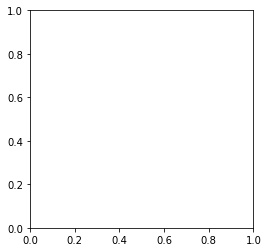

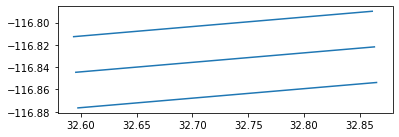

In [132]:
f, ax = plt.subplots(1, figsize = [4, 4])
lines.plot()
plt.show()

In [50]:
inverse_haversine(left_start, 30, ang1)

(32.96406583181291, -116.88136499796992)